## HW03
Deep Learning, GIST RT5101-01, 2021, Spring, (Tue/Thurs 2:30~3:45)
***


How to submit your homework
Submit your jupyter notebook file with the filename of HW03_studentnumber.ipynb on GEL
Ex) HW03_20201106.ipynb

Submission deadline
2021.05.19, Wednesday 23:59 (PM)

Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.

### About the VGGNet

- VGGNet is invented by VGG (Visual Geometry Group) from the University of Oxford ([paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwilz7Ptu4jiAhWIdXAKHYr9BK0QFjAAegQIAhAC&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1409.1556&usg=AOvVaw3u_l2DJveBaeO_vs_qyLMT))
- VGGNet is the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task
- Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.
- There are many other models built on top of VGGNet or based on the 3×3 conv idea of VGGNet for other purposes or other domains.
- In the paper, there is 5 version of VGGNet. Here, you have to implement the VGG-11.

![대체 텍스트](https://cdn-images-1.medium.com/max/1200/1*_1DEx3bHlnBApCWWQ0HgcQ.png)

Your homework consists of the following steps:

1. Build a VGGNet-11
2. visualize the results after training and testing it.
3. apply augmentation by transform function and repeat step 2.
4. compare results of step 2 and 3.

The codes for loading the CIFAR10 dataset will be given.   

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.




## Guide: Load CIFAR10 Dataset
---
Before training the VGGNet-16, Let's load CIFAR10 dataset   
`Note: All the codes in this guide is the same as the lecture material.`



Let's import required python package

Here, ``torchvision`` module provides useful benchmark datasets and image transfromation functions


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Define device configuration (CPU Computation or GPU Computation)

In [87]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [88]:
# Hyper parameters
num_epochs = 10 # number of epochs for train
batch_size = 128 # do not change this value
learning_rate = 0.0001 # do not change this value

Download CIFAR10 dataset

You can check the number of dataset by printing ```len(dataset)```




In [89]:
# CIFAR10 dataset

composed_transforms = transforms.Compose([transforms.Resize((64,64)),
                                         transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                        #for accurate compraision, I added Normalization, because I did normalization on 2nd training (problem3)
                                        ])  # 32,32 to 64,64

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True, 
                                           transform=composed_transforms,                                          
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False, 
                                          transform=composed_transforms)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))


Files already downloaded and verified
Number of train images: 50000
Number of test images: 10000


```torch.utils.data.DataLoader``` shuffles the training data and devides the entire data with ```batch_size```



In [90]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of single image tensor: torch.Size([3, 64, 64])
Size of single image array: (64, 64, 3)



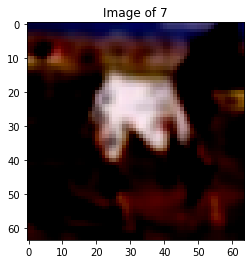

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get single image data
image_tensor, image_label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Size of single image tensor: {}'.format(image_tensor.size()))

# Torch tensor to numpy array
image_array = image_tensor.squeeze().numpy()
image_array = np.transpose(image_array, (1, 2, 0))

print('Size of single image array: {}\n'.format(image_array.shape))

# Plot image
plt.title('Image of {}'.format(image_label))
plt.imshow(image_array)


## Problem1. Implementation of VGGNet-11 (25%)


- Implement the convolutional layers fully connected layers in `self.features` and `self.classifiers`, respectively.
- VGGNet-11 consists of 6 convolutional layers and three fully connected layers.

- Convolutional layers

| layer       | feature maps | kernel size | stride | padding | activation |
|:-------------:|:--------------:|-------------|--------|---------|------------|
| input image | 3            | -           | -      | -       | -          |
|    conv1    |      64      |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool1  |      64      |     2x2     |   2x2  |    -    |      -     |
|    conv2    |      128     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool2  |      128     |     2x2     |   2x2  |    -    |      -     |
|    conv3    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv4    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool3  |      256     |     2x2     |   2x2  |    -    |      -     |
|    conv5    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv6    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool4  |      512     |     2x2     |   2x2  |    -    |      -     |
|    conv7    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv8    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool5  |      512     |     2x2     |   2x2  |    -    |      -     |

- Fully connected layers.

|  layer  | size | activation |
|:-------:|:----:|:----------:|
| linear1 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear2 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear3 | 4096 |  num_class |


[Reference](https://https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11)

※ You can use AvgPooling before classifier because of large memory.

In [92]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            # convolutional layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),#conv1
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv2
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv3
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv4
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool3
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv6
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool4
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv7
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv8
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool5

        )


        self.classifier = nn.Sequential(
            # FClayers
            nn.Linear(in_features=512*2*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Problem2. Train and Test the VGGNet-11 (25%)

1.  Define the criterion and optimizer (use the CrossEntropyLoss and Adam optimizer)
- Using the `train_loader`, train the VGGNet on CIFAR10 dataset for 10 epoch 
- While training, monitor the training loss and accuracy and draw the graph (loss vs. epoch | accuracy vs. epoch) with matplotlib
- After training the model, check the validation loss and accuracy by running your trained model on the test dataset. (Use the `test_loader`)
- While test the model, draw the graph (loss vs epoch | accuracy vs epoch) with matplotlib

In [93]:
# train and test
model = VGGNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []


for epoch in range(num_epochs):

    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()

    for i, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        output = model(data) 

        loss = criterion(output, target)

        output.float()
        loss.float()

        prec1 = accuracy(output.data, target)
        prec1 = prec1[0]

        losses.update(loss.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))

        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader), loss=losses))

        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss_arr.append(losses.avg)
    train_acc_arr.append(top1.avg)
    print("train result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


    model.eval()
    with torch.no_grad():
        val_loss_sum = 0
        val_acc_sum = 0

        losses = AverageMeter()
        top1 = AverageMeter()

        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data) 

            loss = criterion(output, target)

            output.float()
            loss.float()

            prec1 = accuracy(output.data, target)

            prec1 = prec1[0]
            losses.update(loss.item(), data.size(0))
            top1.update(prec1.item(), data.size(0))

            if i % 100 == 0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(test_loader), loss=losses, top1=top1))

        val_loss_arr.append(losses.avg)
        val_acc_arr.append(top1.avg)
        print("Validation result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


Epoch: [0][0/391]	Loss 2.3021 (2.3021)
Epoch: [0][100/391]	Loss 1.9685 (2.1649)
Epoch: [0][200/391]	Loss 1.7435 (1.9976)
Epoch: [0][300/391]	Loss 1.5622 (1.8960)
train result: Loss: 1.8227506128692628, Acc: 30.363

Test: [0/79]	Loss 1.6433 (1.6433)	Prec@1 36.719 (36.719)
Validation result: Loss: 1.6092150388717652, Acc: 38.02

Epoch: [1][0/391]	Loss 1.5763 (1.5763)
Epoch: [1][100/391]	Loss 1.5837 (1.5084)
Epoch: [1][200/391]	Loss 1.2449 (1.4725)
Epoch: [1][300/391]	Loss 1.3293 (1.4337)
train result: Loss: 1.4072491621017456, Acc: 47.55725

Test: [0/79]	Loss 1.1740 (1.1740)	Prec@1 62.500 (62.500)
Validation result: Loss: 1.2609416683197021, Acc: 53.61125

Epoch: [2][0/391]	Loss 1.1890 (1.1890)
Epoch: [2][100/391]	Loss 1.1423 (1.2302)
Epoch: [2][200/391]	Loss 1.1545 (1.2190)
Epoch: [2][300/391]	Loss 1.2086 (1.1988)
train result: Loss: 1.1877834840393067, Acc: 56.26275

Test: [0/79]	Loss 1.0293 (1.0293)	Prec@1 65.625 (65.625)
Validation result: Loss: 1.0955200073242188, Acc: 60.7325

Epoc

<Figure size 432x288 with 0 Axes>

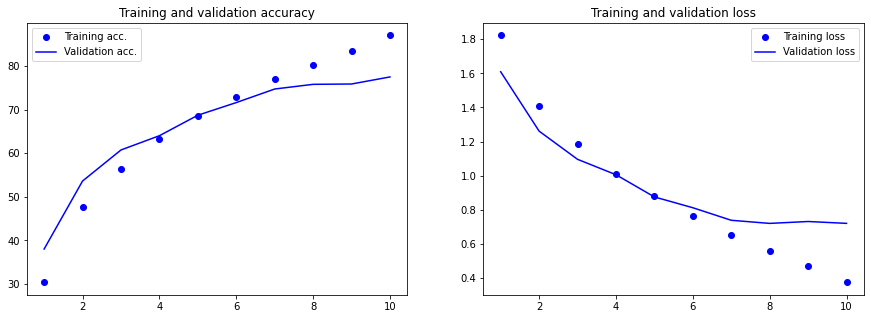

In [94]:
# draw the graph
import matplotlib.pyplot as plt
history = {}

history['acc'] = train_acc_arr
history['loss'] = train_loss_arr

history['val_acc'] = val_acc_arr 
history['val_loss'] = val_loss_arr

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

plt.clf() 
plt.figure(figsize=(15, 5))

epochs = range(1, len(acc) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc.')
plt.plot(epochs, val_acc, 'b', label='Validation acc.')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Problem3. Apply Data Augmentation on your VGGNet-11 (25%)

1.  Use transform.Compose function, apply data augmentation to your VGG model.

[Reference](https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#Compose)

### Example)
- Use RandomHorizontalFlip, flip the image with a probability of 0.5.
- Use RandomRotation, tilt randomly to 10 degrees or less.
- Use ColorJitter, Randomly adjust brightness, contrast, and saturation. (0.2)
- Or something want to apply.

***추가 코멘트
Data Augmentation 적용 한 후의 성능이 얼마나 향상되었는지를 보기위해, test data set에는 data augmentation을 적용안함. 
=> 따라서, test data set은 기본적인 normalization, resize, totensor만 적용하는 transform을 따로 작성함. 

In [95]:
# CIFAR10 dataset
test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ]) # 32,32 to 64,64
                                         
composed_transforms = transforms.Compose([transforms.Resize((64,64)),
                                         transforms.ToTensor(),
                                         # apply additional agmentation
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomRotation(10),
                                          transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                          
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ]) # 32,32 to 64,64

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True, 
                                           transform=composed_transforms,                                          
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False, 
                                          transform=test_transforms)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))

Files already downloaded and verified
Number of train images: 50000
Number of test images: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of single image tensor: torch.Size([3, 64, 64])
Size of single image array: (64, 64, 3)



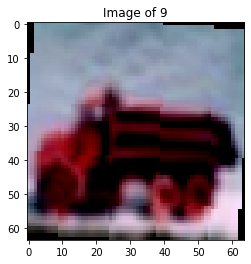

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get single image data
image_tensor, image_label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Size of single image tensor: {}'.format(image_tensor.size()))

# Torch tensor to numpy array
image_array = image_tensor.squeeze().numpy()
image_array = np.transpose(image_array, (1, 2, 0))

print('Size of single image array: {}\n'.format(image_array.shape))

# Plot image
plt.title('Image of {}'.format(image_label))
plt.imshow(image_array)

In [97]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=True):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            # convolutional layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1), nn.ReLU(),#conv1
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv2
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv3
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv4
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool3
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv5
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv6
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool4
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv7
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),nn.ReLU(),#Conv8
            nn.MaxPool2d(kernel_size=2, stride=2),#maxpool5

        )

        #self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            # FClayers
            nn.Linear(in_features=512*2*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Problem4. Apply Data Augmentation on your VGGNet-11 (25%)

1.  In same condition with Problem 1 and 2, train and test your model.
2.  Compare the results of Problem 2 and write a simple discussion.

optimizer, loss function은 앞에서(problem1) 정의했어서, 그대로 사용. 

In [98]:
#optimizer, loss function은 앞에서(problem1) 정의했음. 

train_loss_arr = []
train_acc_arr = []

val_loss_arr = []
val_acc_arr = []


for epoch in range(num_epochs):

    model.train()

    losses = AverageMeter()
    top1 = AverageMeter()

    for i, (data, target) in enumerate(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        output = model(data) 

        loss = criterion(output, target)

        output.float()
        loss.float()

        prec1 = accuracy(output.data, target)
        prec1 = prec1[0]

        losses.update(loss.item(), data.size(0))
        top1.update(prec1.item(), data.size(0))

        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, len(train_loader), loss=losses))

        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss_arr.append(losses.avg)
    train_acc_arr.append(top1.avg)
    print("train result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


    model.eval()
    with torch.no_grad():
        val_loss_sum = 0
        val_acc_sum = 0

        losses = AverageMeter()
        top1 = AverageMeter()

        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data) 

            loss = criterion(output, target)

            output.float()
            loss.float()

            prec1 = accuracy(output.data, target)

            prec1 = prec1[0]
            losses.update(loss.item(), data.size(0))
            top1.update(prec1.item(), data.size(0))

            if i % 100 == 0:
                print('Test: [{0}/{1}]\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(test_loader), loss=losses, top1=top1))

        val_loss_arr.append(losses.avg)
        val_acc_arr.append(top1.avg)
        print("Validation result: Loss: {}, Acc: {}\n".format(losses.avg, top1.avg))


Epoch: [0][0/391]	Loss 0.4138 (0.4138)
Epoch: [0][100/391]	Loss 0.3043 (0.2807)
Epoch: [0][200/391]	Loss 0.3010 (0.2827)
Epoch: [0][300/391]	Loss 0.3623 (0.2875)
train result: Loss: 0.291973388967514, Acc: 89.79125

Test: [0/79]	Loss 0.7294 (0.7294)	Prec@1 78.125 (78.125)
Validation result: Loss: 0.7738072163581848, Acc: 76.58375

Epoch: [1][0/391]	Loss 0.3652 (0.3652)
Epoch: [1][100/391]	Loss 0.1955 (0.1999)
Epoch: [1][200/391]	Loss 0.2618 (0.2026)
Epoch: [1][300/391]	Loss 0.2098 (0.2085)
train result: Loss: 0.21784619067668914, Acc: 92.44575

Test: [0/79]	Loss 0.7615 (0.7615)	Prec@1 78.125 (78.125)
Validation result: Loss: 0.7703411754608154, Acc: 78.40625

Epoch: [2][0/391]	Loss 0.1819 (0.1819)
Epoch: [2][100/391]	Loss 0.1232 (0.1365)
Epoch: [2][200/391]	Loss 0.1655 (0.1503)
Epoch: [2][300/391]	Loss 0.1806 (0.1557)
train result: Loss: 0.16251910709381104, Acc: 94.387

Test: [0/79]	Loss 0.8325 (0.8325)	Prec@1 80.469 (80.469)
Validation result: Loss: 0.7996437891960144, Acc: 78.61625


<Figure size 432x288 with 0 Axes>

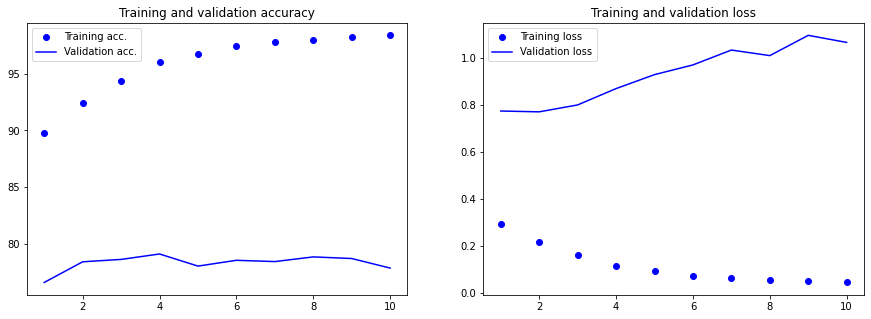

In [99]:
history = {}

history['acc1'] = train_acc_arr
history['loss1'] = train_loss_arr

history['val_acc1'] = val_acc_arr 
history['val_loss1'] = val_loss_arr

acc1 = history['acc1']
val_acc1 = history['val_acc1']
loss1 = history['loss1']
val_loss1 = history['val_loss1']

plt.clf() 
plt.figure(figsize=(15, 5))

epochs = range(1, len(acc) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, acc1, 'bo', label='Training acc.')
plt.plot(epochs, val_acc1, 'b', label='Validation acc.')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss1, 'bo', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

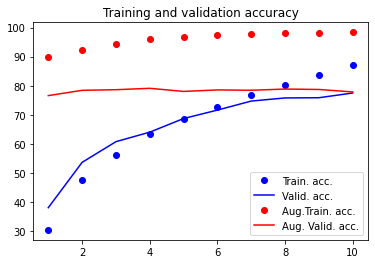

Aug. means augmented	 blue: 1st train, red:2nd train(with augmentation)


In [100]:

plt.plot(epochs, acc, 'bo', label='Train. acc.')
plt.plot(epochs, val_acc, 'b', label= 'Valid. acc.')
plt.plot(epochs, acc1, 'ro', label='Aug.Train. acc.')
plt.plot(epochs, val_acc1, 'r', label='Aug. Valid. acc.')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print("Aug. means augmented\t blue: 1st train, red:2nd train(with augmentation)")

Let's assume: 1st train - the train without augmentation. 2nd train- the train with augmentation. 

I plotted the accuracy and loss for both 1st and 2nd training. 
The plot in the right above cell is the comparison of 1st(blue) and 2nd (red) training.  This figure shows that the 1st train and valid(test) accuracy are higher than those of the 2nd train. This means that applying data augmentation has a positive effect on the performance of deep learning. 

But, the validation(test) accuracy of 2nd train was not increased as much as training accuracy did. This might be resulted from difference in transforms of training and test dataset. I applied augmented only train dataset of 2nd train. The problem of test accuray of the 2nd train might be solved with higher epoch.  

However, unfortunately, the epoch was set as ten by considering the computational cost. This epoch is too small for a neural network to learn enough. 
If I have enough time and computational resources, I can increase epoch up to 100 or more, then the accuracy of 2nd training (with augmentation) will be much higher with better learning. 